In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression 
import matplotlib.pylab as pylab
import math,time
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

test_set_size_percentage = 20 
import pandas as pd
from pandas import read_csv
from sklearn.metrics import r2_score,mean_squared_error 

Using TensorFlow backend.


In [2]:
data=pd.read_csv('dataset/irondata.csv',parse_dates=['date'])

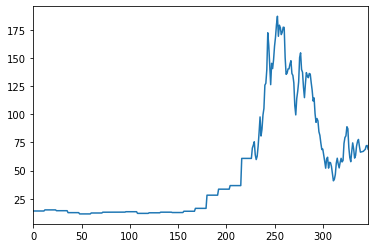

In [3]:
data['price'].plot()
data['price_lag']=data['price'].shift(1)
data=data.set_index('date')
#data['rolling_mean_price']=data['price_lag'].rolling(2, min_periods=1).sum()
data=data.dropna()

In [4]:
# function for min-max normalization of Iron Ore 
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['price'] = min_max_scaler.fit_transform(df.price.values.reshape(-1,1))
    df['price_lag'] = min_max_scaler.fit_transform(df.price_lag.values.reshape(-1,1))
    #df['rolling_mean_price'] = min_max_scaler.fit_transform(df.rolling_mean_price.values.reshape(-1,1))
    return df

In [5]:
# normalize stock
df = data.copy()
df = normalize_data(df)
df.head()

,price,price_lag
date,,
1990-02-28,0.014795,0.014795
1990-03-31,0.014795,0.014795
1990-04-30,0.014795,0.014795
1990-05-31,0.014795,0.014795
1990-06-30,0.014795,0.014795


In [6]:
train=df[:335]
test = df[335:-1]
forecast = df[-1:]

In [7]:
test

,price,price_lag
date,,
2018-01-31,0.366073,0.343083
2018-02-28,0.376714,0.366073
2018-03-31,0.340693,0.376714
2018-04-30,0.312297,0.340693
2018-05-31,0.314004,0.312297
2018-06-30,0.315313,0.314004
2018-07-31,0.316394,0.315313
2018-08-31,0.321914,0.316394
2018-09-30,0.326353,0.321914


In [8]:
train_data_raw = train.as_matrix()
test_data_raw = test.as_matrix()
forecast_data_raw = forecast.as_matrix()

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
forecast_data_raw

array([[0.32692198, 0.34626985]])

In [10]:
x_train = train_data_raw[:,1:] #without price column of train
y_train = train_data_raw[:,0] #with price column of train

x_test = test_data_raw[:,1:] #without price column of train
y_test = test_data_raw[:,0]  #with price column of train

x_forecast = forecast_data_raw[:,1:]
y_forecast = forecast_data_raw[:,0]

In [11]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)
print('x_forecast.shape = ', x_forecast.shape)
print('y_forecast.shape ',y_forecast.shape)

x_train.shape =  (335, 1)
y_train.shape =  (335,)
x_test.shape =  (11, 1)
y_test.shape =  (11,)
x_forecast.shape =  (1, 1)
y_forecast.shape  (1,)


In [12]:
x_train.shape[0]

335

In [13]:
#Reshape data for (Sample,Timestep,Features) 
x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))
#x_forecast = x_forecast.reshape((x_forecast.shape[0],1,x_test.shape[1]))
x_test.shape

(11, 1, 1)

In [14]:
d = 0.3
model = Sequential()

model.add(LSTM(32, input_shape=(1,1), return_sequences=True)) #timestamp with 2 feature
#model.add(Dropout(d))

model.add(LSTM(32, input_shape=(1,1), return_sequences=False))
#model.add(Dropout(d))

model.add(Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

# adam = keras.optimizers.Adam(decay=0.2)

start = time.time()
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
print("Compilation Time : ", time.time() - start)

Compilation Time :  0.08362555503845215


In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 32)             4352      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 13,217
Trainable params: 13,217
Non-trainable params: 0
_________________________________________________________________


In [16]:
#Fit model with history to check for overfitting
history = model.fit(x_train,y_train,epochs=80,shuffle=False)


Epoch 1/80
335/335 [==============================] - 1s 2ms/step - loss: 0.1100 - accuracy: 0.0358    
Epoch 2/80
335/335 [==============================] - 0s 80us/step - loss: 0.1063 - accuracy: 0.0358   
Epoch 3/80
335/335 [==============================] - 0s 71us/step - loss: 0.1022 - accuracy: 0.0358   
Epoch 4/80
335/335 [==============================] - 0s 98us/step - loss: 0.0976 - accuracy: 0.0358   
Epoch 5/80
335/335 [==============================] - 0s 74us/step - loss: 0.0926 - accuracy: 0.0358   
Epoch 6/80
335/335 [==============================] - 0s 84us/step - loss: 0.0869 - accuracy: 0.0358
Epoch 7/80
335/335 [==============================] - 0s 77us/step - loss: 0.0808 - accuracy: 0.0358
Epoch 8/80
335/335 [==============================] - 0s 83us/step - loss: 0.0745 - accuracy: 0.0358
Epoch 9/80
335/335 [==============================] - 0s 80us/step - loss: 0.0687 - accuracy: 0.0358
Epoch 10/80
335/335 [==============================] - 0s 74us/step - loss:

335/335 [==============================] - 0s 74us/step - loss: 0.0011 - accuracy: 0.0388   
Epoch 78/80
335/335 [==============================] - 0s 83us/step - loss: 0.0011 - accuracy: 0.0388   
Epoch 79/80
335/335 [==============================] - 0s 63us/step - loss: 0.0011 - accuracy: 0.0388   
Epoch 80/80
335/335 [==============================] - 0s 86us/step - loss: 0.0011 - accuracy: 0.0388   


In [17]:
# serialize model to JSON
model_json = model.to_json()
with open("model-weight/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
# load json and create model
from keras.models import model_from_json
json_file = open('model-weight/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [19]:
pred_price = model.predict(x_test,batch_size=1,verbose=1)

11/11 [==============================] - 0s 14ms/step


In [20]:
def denormalize(df, normalized_value): 
    df = df['price'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(data, pred_price)
newy_test = denormalize(data, y_test)

In [21]:
newp

array([[71.70426],
       [75.37008],
       [77.08456],
       [71.32622],
       [66.88008],
       [67.14499],
       [67.34828],
       [67.51637],
       [68.37641],
       [69.07032],
       [71.95661]], dtype=float32)

In [22]:
newy_test

array([[75.78],
       [77.65],
       [71.32],
       [66.33],
       [66.63],
       [66.86],
       [67.05],
       [68.02],
       [68.8 ],
       [72.02],
       [72.3 ]])

In [23]:
def model_score(model, x_train, y_train, x_test, y_test):
    trainScore = model.evaluate(x_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(x_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, x_train, y_train, x_test, y_test)

Train Score: 0.00109 MSE (0.03 RMSE)
Test Score: 0.00026 MSE (0.02 RMSE)


(0.001090176828948819, 0.0002634339325595647)

In [24]:
# plt.figure(figsize=(15, 5));
# plt.plot(newp,color='red', label='Prediction')
# plt.plot(newy_test,color='blue', label='Actual')
# plt.legend(loc='best')
# plt.show()

In [25]:
act_pred = pd.concat([pd.DataFrame(newp), pd.DataFrame(newy_test)], axis=1)
act_pred.columns = ['Predicted', 'Actual']

In [26]:
act_pred

,Predicted,Actual
0,71.704262,75.78
1,75.370079,77.65
2,77.084557,71.32
3,71.326218,66.33
4,66.880081,66.63
5,67.144989,66.86
6,67.348282,67.05
7,67.516373,68.02
8,68.376411,68.80
9,69.070320,72.02


Text(0, 0.5, 'Price')

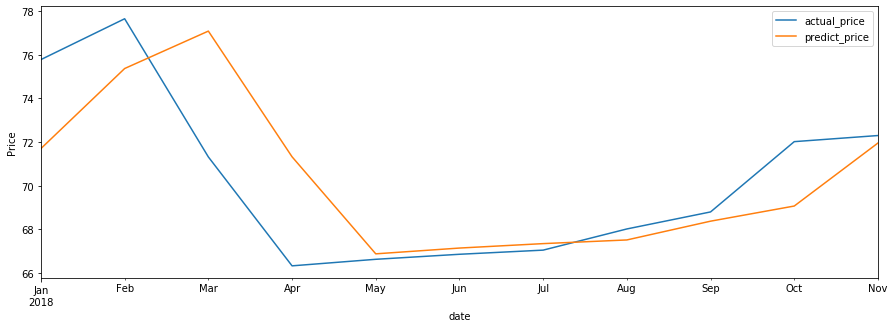

In [27]:
# In normalize condition
new_df = pd.DataFrame(columns=['date','actual_price','predict_price'])
new_df['date'] = test.index
new_df['actual_price'] = act_pred['Actual'].values
new_df['predict_price'] = act_pred['Predicted'].values
new_df = new_df.set_index('date')
new_df.plot(figsize=(15,5))
plt.ylabel("Price")

# forecast till 2020 #

In [28]:
#x_forecast = x_forecast.reshape((x_forecast.shape[0],1,x_forecast.shape[1]))  np.reshape(test_forecast,(1,1,2))
pp = x_forecast.copy()
xx_forecast = np.reshape(pp,(1,1,1))
xx_forecast

array([[[0.34626985]]])

In [29]:
forecast_val=[]
t=xx_forecast[0][0][0] #take the price lag of last value
t

0.34626984578614917

In [30]:
forecast_data_index = pd.date_range(start='1/1/2019', periods=12,freq='M')
forecast_data_index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')

In [31]:
forecast_data = pd.DataFrame()
forecast_data['date'] = forecast_data_index

In [32]:
for i in range(1,len(forecast_data)+1):
    m=model.predict(xx_forecast)
    print("predict price = ",m.tolist()[0][0])
    print("last price_lag = ", t)
    forecastdf=pd.DataFrame(columns=['price_lag'])
    forecastdf['price_lag']=[t,m.tolist()[0][0]]
    forecastdf['rolling_mean_price']=forecastdf['price_lag'].rolling(2, min_periods=1).sum()
    print(forecastdf)
    xx_forecast=forecastdf[-1:]['price_lag']
    print("matrix",xx_forecast)
    xx_forecast = xx_forecast.as_matrix()
    print("matrix_dd",xx_forecast)
    #x_forecast = x_forecast.reshape((x_forecast.shape[0],1,x_forecast.shape[1]))
    xx_forecast = np.reshape(xx_forecast,(1,1,1))
    t=m.tolist()[0][0]
    forecast_val.append(m.tolist()[0][0])

predict price =  0.3457532525062561
last price_lag =  0.34626984578614917
   price_lag  rolling_mean_price
0   0.346270            0.346270
1   0.345753            0.692023
matrix 1    0.345753
Name: price_lag, dtype: float64
matrix_dd [0.34575325]
predict price =  0.345287024974823
last price_lag =  0.3457532525062561
   price_lag  rolling_mean_price
0   0.345753            0.345753
1   0.345287            0.691040
matrix 1    0.345287
Name: price_lag, dtype: float64
matrix_dd [0.34528702]
predict price =  0.34486645460128784
last price_lag =  0.345287024974823
   price_lag  rolling_mean_price
0   0.345287            0.345287
1   0.344866            0.690153
matrix 1    0.344866
Name: price_lag, dtype: float64
matrix_dd [0.34486645]
predict price =  0.3444870412349701
last price_lag =  0.34486645460128784
   price_lag  rolling_mean_price
0   0.344866            0.344866
1   0.344487            0.689353
matrix 1    0.344487
Name: price_lag, dtype: float64
matrix_dd [0.34448704]
predict

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [33]:
forecast_val

[0.3457532525062561,
 0.345287024974823,
 0.34486645460128784,
 0.3444870412349701,
 0.34414491057395935,
 0.34383654594421387,
 0.34355854988098145,
 0.34330806136131287,
 0.3430823087692261,
 0.3428790271282196,
 0.34269586205482483,
 0.34253090620040894]

In [34]:
forecast_data['forecast_price'] = forecast_val #normalize value

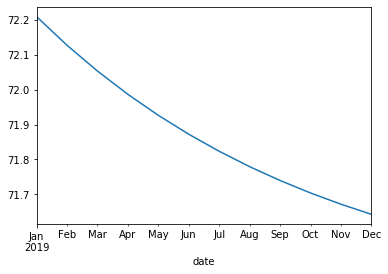

In [35]:
new_forecast = denormalize(data, np.array(forecast_val))
forecast_data['denorm_price'] = new_forecast
forecast_data = forecast_data.set_index('date')
forecast_data.denorm_price.plot()

In [36]:
forecast_data

,forecast_price,denorm_price
date,,
2019-01-31,0.345753,72.209219
2019-02-28,0.345287,72.127289
2019-03-31,0.344866,72.053382
2019-04-30,0.344487,71.986708
2019-05-31,0.344145,71.926585
2019-06-30,0.343837,71.872396
2019-07-31,0.343559,71.823544
2019-08-31,0.343308,71.779526
2019-09-30,0.343082,71.739854


In [37]:
new_df

,actual_price,predict_price
date,,
2018-01-31,75.78,71.704262
2018-02-28,77.65,75.370079
2018-03-31,71.32,77.084557
2018-04-30,66.33,71.326218
2018-05-31,66.63,66.880081
2018-06-30,66.86,67.144989
2018-07-31,67.05,67.348282
2018-08-31,68.02,67.516373
2018-09-30,68.80,68.376411


In [38]:
act_pred

,Predicted,Actual
0,71.704262,75.78
1,75.370079,77.65
2,77.084557,71.32
3,71.326218,66.33
4,66.880081,66.63
5,67.144989,66.86
6,67.348282,67.05
7,67.516373,68.02
8,68.376411,68.80
9,69.070320,72.02
